In [1]:
import os
import re
import time
import pickle
import asyncio
import nest_asyncio
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from typing import List

from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.embeddings import ClovaXEmbeddings
from langchain_community.chat_models import ChatClovaX
from pymilvus import connections, utility
from langchain_community.vectorstores.milvus import Milvus
from langchain.schema import BaseRetriever
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel

In [2]:
class ISBNMergingRetriever(BaseRetriever):
    """
    BaseRetriever를 감싸서, 검색 결과를 ISBN 기준으로 그룹화하고
    각 그룹의 청크를 하나의 Document로 병합하여 반환한다.
    """

    base_retriever: BaseRetriever  # Pydantic 필드 선언

    def _get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.base_retriever.get_relevant_documents(query)
        grouped = {}
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            grouped.setdefault(isbn, []).append(doc)
        merged_docs = []
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            merged_doc = Document(page_content=combined_text, metadata=merged_meta)
            print(
                f"[디버그] ISBN: {isbn}, 병합된 청크 수: {len(doc_list)}, 병합 텍스트 길이: {len(combined_text)}"
            )
            merged_docs.append(merged_doc)
        return merged_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        docs = await self.base_retriever.aget_relevant_documents(query)
        grouped = {}
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            grouped.setdefault(isbn, []).append(doc)
        merged_docs = []
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )
        return merged_docs

    def add_documents(self, documents: List[Document], **kwargs) -> None:
        pass

    def get_type(self) -> str:
        return "isbn_merging_retriever"

In [3]:
# text는 아래와 같은 형태로 들어가서 청크

# 제목 : [값]
# 분류 : [값]
# 저자 : [값]
# 저자소가 : [값]
# 책 소개 : [값]
# 목차 : [값]
# 출판사리뷰 : [값]

# 임베딩 pkl에 포함된 메타데이터 컬럼과 (임베딩,원본text)로 묶인 컬럼

# metadata_columns = ['ISBN', '페이지', '가격', '제목', '저자']
# vector_doc_columns = ['제목', '분류', '저자','저자소개', '책소개', '목차', '출판사리뷰','추천사']

In [5]:
# 환경설정, 임베딩, 문서 구성 등

previous_additional_question_embeddings = []


def is_similar_question(new_emb, prev_embeds, threshold=0.65):
    if not prev_embeds:
        return False
    sim_scores = cosine_similarity([new_emb], prev_embeds)[0]
    max_score = max(sim_scores)
    print(f"[중복 유사도 판단] Max = {max_score:.3f}")
    return max_score > threshold


load_dotenv(dotenv_path=r"C:\Kill_the_RAG\Project\Aiffel_final_project\.env")

os.environ["NCP_CLOVASTUDIO_API_KEY"] = os.getenv("NCP_CLOVASTUDIO_API_KEY")
os.environ["NCP_CLOVASTUDIO_API_URL"] = os.getenv(
    "NCP_CLOVASTUDIO_API_URL", "https://clovastudio.stream.ntruss.com/"
)

connections.connect(
    alias="default",
    host=os.getenv("MILVUS_HOST", "localhost"),
    port=os.getenv("MILVUS_PORT", "19530"),
)

ncp_embeddings = ClovaXEmbeddings(model="bge-m3")
llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)

In [6]:
embedding_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"
if os.path.exists(embedding_file):
    with open(embedding_file, "rb") as f:
        saved_data = pickle.load(f)
    all_text_embedding_pairs = saved_data["embeddings"]
    all_metadata_list = saved_data["metadata"]
    print("임베딩 데이터 불러오기")
else:
    raise FileNotFoundError(f"임베딩 파일을 찾을 수 없습니다: {embedding_file}")

metadata_mapping = {
    "ISBN": "ISBN",
    "페이지": "page",
    "가격": "price",
    "제목": "title",
    "저자": "author",
    "분류": "category",
    "저자소개": "author_intro",
    "책소개": "book_intro",
    "목차": "table_of_contents",
    "출판사리뷰": "publisher_review",
    "추천사": "recommendation",
}

all_metadata_list_mapped = []
for meta in all_metadata_list:
    mapped_meta = {metadata_mapping.get(key, key): value for key, value in meta.items()}
    all_metadata_list_mapped.append(mapped_meta)

documents = [
    Document(page_content=pair[0], metadata=meta)
    for pair, meta in zip(all_text_embedding_pairs, all_metadata_list_mapped)
]

임베딩 데이터 불러오기


In [7]:
collection_name = "book_rag_db"
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

vectorstore = Milvus(
    embedding_function=ncp_embeddings,
    collection_name=collection_name,
    connection_args={"host": "localhost", "port": "19530"},
    auto_id=True,
)

texts = [pair[0] for pair in all_text_embedding_pairs]
embeds = [pair[1] for pair in all_text_embedding_pairs]


def precomputed_embed_documents(cls, input_texts):
    if input_texts != texts:
        raise ValueError(
            "ERROR : 입력 텍스트 순서가 사전 계산된 임베딩과 일치하지 않음"
        )
    return embeds


ClovaXEmbeddings.embed_documents = classmethod(precomputed_embed_documents)
vectorstore.add_texts(
    texts=texts, metadatas=all_metadata_list_mapped, embeddings=embeds
)

C:\Users\computer\AppData\Local\Temp\ipykernel_3716\3539998358.py:5: LangChainDeprecationWarning: The class `Milvus` was deprecated in LangChain 0.2.0 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-milvus package and should be used instead. To use it run `pip install -U :class:`~langchain-milvus` and import as `from :class:`~langchain_milvus import MilvusVectorStore``.
  vectorstore = Milvus(


[456973556190020593,
 456973556190020594,
 456973556190020595,
 456973556190020596,
 456973556190020597,
 456973556190020598,
 456973556190020599,
 456973556190020600,
 456973556190020601,
 456973556190020602,
 456973556190020603,
 456973556190020604,
 456973556190020605,
 456973556190020606,
 456973556190020607,
 456973556190020608,
 456973556190020609,
 456973556190020610,
 456973556190020611,
 456973556190020612,
 456973556190020613,
 456973556190020614,
 456973556190020615,
 456973556190020616,
 456973556190020617,
 456973556190020618,
 456973556190020619,
 456973556190020620,
 456973556190020621,
 456973556190020622,
 456973556190020623,
 456973556190020624,
 456973556190020625,
 456973556190020626,
 456973556190020627,
 456973556190020628,
 456973556190020629,
 456973556190020630,
 456973556190020631,
 456973556190020632,
 456973556190020633,
 456973556190020634,
 456973556190020635,
 456973556190020636,
 456973556190020637,
 456973556190020638,
 456973556190020639,
 456973556190

In [8]:
# 기존 dense_retriever 생성 → custom retriever로 감싸기

dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
merged_retriever = ISBNMergingRetriever(base_retriever=dense_retriever)

dpr_qa_chain = RetrievalQA.from_chain_type(
    llm=llm_clova, retriever=merged_retriever, return_source_documents=True
)


def extract_field(text, field_name):
    pattern = rf"{re.escape(field_name)}\s*:\s*(.*)"
    match = re.search(pattern, text)
    return match.group(1).strip() if match else ""


MIN_INFO_LENGTH = 10

In [9]:
decision_prompt_template = PromptTemplate(
    template="""
[대화 맥락]
사용자 대화 내역:
{{ history }}
사용자의 최신 질문: "{{ query }}"

[역할 및 목표]
{{ role_instructions }}
현재 대화 상황과 질문의 맥락을 분석하여 아래 중 하나의 행동만을 출력해라.
- "추천": 사용자가 책 추천을 명확히 요청하거나, 선호도 정보(예: 선호하는 카테고리, 선호하는 작가, 책을 찾는 목적, 사전지식 등)가 **구체적**이고 충분하다고 판단되는 경우에만.
- "추가 질문": 위 조건을 충족하지 못해, 추가로 선호도 정보를 더 알아내야 할 경우, 새로운 선호도 정보를 얻을 수 있는 구체적인 추가 질문을 생성할 것.
출력 형식 (반드시 아래 내용만 출력):
행동: "<추천 또는 추가 질문>"
추가 질문: "<추가 질문인 경우 구체적인 추가 질문을, 추천인 경우 빈 문자열>"
""",
    input_variables=["history", "query", "role_instructions"],
    template_format="jinja2",
)

final_query_generation_template = PromptTemplate(
    template="""
[대화 요약]
{{ history }}

[사용자 요청]
{{ query }}

[페르소나 정보]
{{ persona_info }}

[사용자 선호도]
{{ preferences }}

위 정보를 바탕으로, 사용자가 제공한 선호도 정보(카테고리, 작가, 목적 등)를 모두 반영하여, 책 추천에 유용한 최종 검색 쿼리만을 생성해라.
출력 형식:
쿼리: <최종 검색 쿼리>
- 반드시 위 형식만을 사용하고, 추가 설명이나 안내 문구는 포함하지 말라.
- "최종 검색 쿼리"는 질문 형태가 아니어야 하며, '추가 질문'이라는 표현은 사용하지 말라.
""",
    input_variables=["history", "query", "persona_info", "preferences"],
    template_format="jinja2",
)

# 페르소나별 Pipeline 클래스

literature_role = "너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 섬세하게 파악하여, 감성적인 어투를 활용해 책을 추천해라."
science_role = "너는 정확하고 논리적인 과학/기술 도서 추천 챗봇이다. 사용자의 관심 분야와 요구를 분석하여, 명확하고 구체적인 정보를 활용하여 책을 추천해라."
general_role = "너는 친절하고 신뢰할 수 있는 범용 도서 추천 챗봇이다. 사용자의 관심사와 목적을 파악하여, 다양한 분야의 책을 적절하게 추천해라. 문학, 과학 외에도 자기계발, 역사, 에세이, 경제경영 등 모든 장르에 유연하게 대응해라."

In [10]:
import contextlib
from langchain_core.runnables import RunnableSequence


class SummarizeFinalQueryChain:
    async def __call__(self, input_data: dict) -> dict:
        query = input_data.get("final_query") or input_data.get("text", "")
        prompt = f"다음 내용을 하나의 자연스러운 문장으로 정제해줘:\n{query}\n정제된 검색 쿼리:"
        result_text = await async_invoke_llm(prompt, "최종 쿼리 정제")
        return {"text": result_text.strip()}


async def async_invoke(chain: LLMChain, vars_dict: dict, step_name: str) -> dict:
    try:
        print(f"\n[디버그] {step_name} 호출 전 변수: {vars_dict}")
        result = await asyncio.to_thread(chain.invoke, vars_dict)
        print(f"\n[디버그] {step_name} 결과: {result}")
        return result
    except Exception as e:
        print(f"[에러] {step_name}에서 예외 발생: {str(e)}")
        return {"text": ""}


async def async_invoke_llm(prompt: str, step_name: str) -> str:
    try:
        print(f"\n[디버그] {step_name} 프롬프트 호출:\n{prompt}")
        response = await asyncio.to_thread(llm_clova.invoke, prompt)
        result_text = response.text().strip()
        print(f"\n[디버그] {step_name} 응답: {result_text}")
        return result_text
    except Exception as e:
        print(f"[에러] {step_name}에서 예외 발생: {str(e)}")
        return ""

In [11]:
class BaseRAGPipeline:
    def __init__(self, config, llm, retriever, qa_chain, documents):
        self.config = config
        self.llm = llm
        self.retriever = retriever
        self.qa_chain = qa_chain
        self.documents = documents

        # 사용자와 LLM 히스토리 분리
        self.user_history = []
        self.llm_history = []

        self.user_preferences = defaultdict(list)
        self.preferences_text = ""
        self.preference_update_count = 0

        # 마지막 추천 결과 저장 (병합된 Document 리스트)
        self.last_recommendations = []

        self.decision_chain = LLMChain(llm=self.llm, prompt=decision_prompt_template)
        self.final_query_generation_chain = LLMChain(
            llm=self.llm, prompt=final_query_generation_template
        )

    def robust_parse_decision_response(self, response_text):
        action_match = re.search(r"행동\s*[:：]\s*\"?([^\"\n]+)\"?", response_text)
        action = action_match.group(1).strip() if action_match else None

        book_info_match = re.search(
            r"추천\s*책\s*정보\s*[:：]\s*\"?([^\"\n]+)\"?", response_text
        )
        book_info = book_info_match.group(1).strip() if book_info_match else ""

        follow_match = re.search(
            r"추가\s*질문\s*[:：]\s*\"?([^\"\n]+)\"?", response_text
        )
        additional_question = follow_match.group(1).strip() if follow_match else ""
        return action, book_info, additional_question

    async def get_final_query(self, final_query_vars):
        composite_final_chain = RunnableSequence(
            *[self.final_query_generation_chain, SummarizeFinalQueryChain()]
        )
        composite_result = await composite_final_chain.ainvoke(final_query_vars)
        final_query = composite_result.get("text", "").strip()
        return final_query

    async def summarize_user_preferences(self, existing_preferences, new_input):
        prompt = (
            f"다음 사용자 선호도 내용들을 하나의 자연스러운 문장으로 요약해줘:\n"
            f"기존 선호도: {existing_preferences}\n"
            f"새로운 입력: {new_input}\n"
            f"요약된 선호도:"
        )
        return await async_invoke_llm(prompt, "사용자 선호도 요약")

    async def generate_answer(self, query):
        # 일반 QA 시나리오: RetrievalQA 체인을 사용
        author_match = re.search(r"(?:저자|작가)\s*[:：]\s*(\S+)", query)
        if author_match:
            author_name = author_match.group(1).strip().lower()
            dense_results = self.qa_chain.invoke(query)["source_documents"]
            keyword_results = [
                doc
                for doc in self.documents
                if doc.metadata.get("author", "").strip().lower() == author_name
            ]
            source_docs = list(
                {
                    doc.metadata.get("ISBN"): doc
                    for doc in (dense_results + keyword_results)
                    if doc.metadata.get("ISBN")
                }.values()
            )
        else:
            result = self.qa_chain.invoke(query)
            source_docs = result["source_documents"]

        retrieved_isbns = set()
        for doc in source_docs:
            isbn = doc.metadata.get("ISBN")
            if isbn:
                retrieved_isbns.add(isbn)

        aggregated_docs = []
        for isbn in retrieved_isbns:
            book_docs = [
                doc for doc in self.documents if doc.metadata.get("ISBN") == isbn
            ]
            if not book_docs:
                continue
            aggregated_text = "\n".join([doc.page_content for doc in book_docs])
            aggregated_docs.append(
                Document(page_content=aggregated_text, metadata=book_docs[0].metadata)
            )

        formatted_answers = []
        for doc in aggregated_docs:
            metadata = doc.metadata
            title = metadata.get("title") or extract_field(doc.page_content, "제목")
            author = metadata.get("author") or extract_field(doc.page_content, "저자")
            aggregated_text = doc.page_content
            book_intro = extract_field(aggregated_text, "책소개")
            publisher_review = extract_field(aggregated_text, "출판사리뷰")
            recommendation_field = extract_field(aggregated_text, "추천사")

            if book_intro and len(book_intro.strip()) >= MIN_INFO_LENGTH:
                selected_info = book_intro
            elif publisher_review and len(publisher_review.strip()) >= MIN_INFO_LENGTH:
                selected_info = publisher_review
            elif (
                recommendation_field
                and len(recommendation_field.strip()) >= MIN_INFO_LENGTH
            ):
                selected_info = recommendation_field
            else:
                selected_info = ""

            if not selected_info:
                reason = "추천 정보 생성 불가"
            else:
                reason_prompt = (
                    f"다음 정보와 검색에 활용된 쿼리를 참고하여, "
                    f"이 책이 추천되는 이유를 명확하게 요약해라.\n"
                    f"정보:\n{selected_info}"
                )
                generated_reason = await async_invoke_llm(
                    reason_prompt, "추천 이유 생성"
                )
                if (
                    not generated_reason
                    or len(generated_reason) < 10
                    or "추천 정보 생성 불가" in generated_reason
                ):
                    reason = "추천 정보 생성 불가"
                else:
                    reason = generated_reason

            formatted = f"책 제목: {title}\n저자: {author}\n추천 이유: {reason}"
            formatted_answers.append(formatted)

        answer = "\n\n".join(formatted_answers)
        refined_answer = await async_invoke_llm(
            f"아래 원본 추천 결과를 읽고, 각 책의 정보를 다음 형식에 맞춰 재작성해라.\n\n"
            f"형식:\n책 제목: <책 제목>\n저자: <저자>\n추천 이유: <추천 이유>\n\n"
            f"원본 추천 결과:\n{answer}\n\n"
            f"출력 시, 반드시 위 형식만을 사용하고 불필요한 안내 문구는 포함하지 말아라.",
            "추천 결과 재정제",
        )
        return refined_answer, None

    async def _summarize_chunk_with_llm(self, text: str) -> str:
        prompt = (
            f"다음 책 정보를 200자 이내로 간략히 요약해줘:\n" f"{text}\n\n" f"요약:"
        )
        summary = await async_invoke_llm(prompt, "chunk summary")
        if not summary or len(summary) < 10:
            summary = "별도의 상세 정보가 충분치 않습니다."
        return summary

    def _merge_documents_by_isbn(self, isbn: str) -> Document:
        # self.documents에서 해당 ISBN에 해당하는 모든 Document를 필터링하여 병합
        docs = [doc for doc in self.documents if doc.metadata.get("ISBN") == isbn]
        if not docs:
            return None
        combined_text = "\n".join(doc.page_content for doc in docs)
        merged_meta = docs[0].metadata
        return Document(page_content=combined_text, metadata=merged_meta)

    async def _some_simple_recommendation(self, final_query):
        # 1단계: 기본 Retriever를 사용해 상위 3개의 Document(청크)를 가져옴
        source_docs = self.retriever.get_relevant_documents(final_query)
        top_docs = source_docs[:3]
        # 2단계: 각 상위 결과의 ISBN으로 self.documents에서 전체 청크를 병합
        merged_top_docs = []
        for doc in top_docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            merged_doc = self._merge_documents_by_isbn(isbn)
            if merged_doc:
                merged_top_docs.append(merged_doc)
                print(
                    f"[추천 디버그] ISBN: {isbn}, 병합된 전체 청크 길이: {len(merged_doc.page_content)}"
                )
        # 3단계: 각 병합된 Document에서 추천 이유를 생성
        recommendations = []
        for doc in merged_top_docs:
            metadata = doc.metadata
            title = metadata.get("title", "제목 정보 없음")
            author = metadata.get("author", "저자 정보 없음")
            # 추출: 책소개, 출판사리뷰, 추천사
            book_intro = extract_field(doc.page_content, "책소개")
            publisher_review = extract_field(doc.page_content, "출판사리뷰")
            recommendation_field = extract_field(doc.page_content, "추천사")
            if book_intro and len(book_intro.strip()) >= MIN_INFO_LENGTH:
                selected_info = book_intro
            elif publisher_review and len(publisher_review.strip()) >= MIN_INFO_LENGTH:
                selected_info = publisher_review
            elif (
                recommendation_field
                and len(recommendation_field.strip()) >= MIN_INFO_LENGTH
            ):
                selected_info = recommendation_field
            else:
                selected_info = ""
            if selected_info:
                summary = await self._summarize_chunk_with_llm(selected_info)
            else:
                summary = "별도의 상세 정보가 충분치 않습니다."
            if len(summary) > 150:
                summary = summary[:150] + "..."
            recommendation_text = (
                f"책 제목: {title}\n" f"저자: {author}\n" f"추천 이유: {summary}"
            )
            recommendations.append(recommendation_text)
        # 저장: 후속 질의에 활용하기 위해 last_recommendations에 저장
        self.last_recommendations = merged_top_docs
        if not recommendations:
            return "해당 검색 쿼리에 대한 직접 추천 결과가 없습니다."
        return "\n\n".join(recommendations)

    # 후속 질문: 특정 추천 결과(예: A, B, C)에 대해 상세 설명 요청 처리
    async def handle_followup_on_recommendation(self, user_input):
        selected_index = None
        if "1" in user_input or "A" in user_input.upper():
            selected_index = 0
        elif "2" in user_input or "B" in user_input.upper():
            selected_index = 1
        elif "3" in user_input or "C" in user_input.upper():
            selected_index = 2

        if selected_index is not None and selected_index < len(
            self.last_recommendations
        ):
            doc = self.last_recommendations[selected_index]
            detail_prompt = (
                f"다음 책 정보에 대해 더 자세한 설명을 해줘:\n\n{doc.page_content}\n\n"
                "자세한 설명:"
            )
            result = await async_invoke_llm(detail_prompt, "후속 상세 설명")
            return result
        else:
            return "잘못된 선택입니다."

    # 후속 질문: 추천 결과와 비슷한 책 다시 추천 처리
    async def recommend_similar_books(self, user_input):
        selected_index = None
        if "1" in user_input or "A" in user_input.upper():
            selected_index = 0
        elif "2" in user_input or "B" in user_input.upper():
            selected_index = 1
        elif "3" in user_input or "C" in user_input.upper():
            selected_index = 2

        if selected_index is not None and selected_index < len(
            self.last_recommendations
        ):
            doc = self.last_recommendations[selected_index]
            author = doc.metadata.get("author", "")
            category = doc.metadata.get("category", "")
            query_for_similar = f"{author} {category} 비슷한 책"
            new_docs = self.retriever.get_relevant_documents(query_for_similar)
            top_docs = new_docs[:3]
            recs = []
            for nd in top_docs:
                t = nd.metadata.get("title", "제목 정보 없음")
                recs.append(f"- {t}")
            return "\n".join(recs)
        else:
            return "잘못된 선택입니다."

    async def search_and_generate_answer(self, user_query, force_recommendation=False):
        self.preferences_text = " ".join(self.user_preferences["preferences"])
        query_summary = "\n".join(self.user_history[-5:])

        if self.config.get("persona") == "Literature":
            persona_info = "감성, 현재 기분, 선호하는 문학 장르 및 작가 정보"
        elif self.config.get("persona") == "Science":
            persona_info = "초심자 여부, 관심 분야, 구체적인 기술 정보"
        elif self.config.get("persona") == "General":
            persona_info = "장르, 책을 찾는 이유, 독서 취향 정보"
        else:
            persona_info = ""

        if force_recommendation:
            action = "추천"
            print("[디버그] force_recommendation 적용: 추천 행동으로 전환합니다.")
            additional_question = ""
        else:
            prompt_vars = {
                "history": query_summary,
                "query": user_query,
                "role_instructions": self.config["role_instructions"],
            }
            decision_result = await async_invoke(
                self.decision_chain, prompt_vars, "행동 결정"
            )
            decision_text = decision_result.get("text", "").strip()
            print(f"\n[디버그] Decision 응답: {decision_text}")
            action, _, additional_question = self.robust_parse_decision_response(
                decision_text
            )
            print(f"[디버그] 행동: {action}")

        if action == "추가 질문":
            try:
                add_q_emb = ncp_embeddings.embed_query(additional_question)
            except Exception as e:
                print(f"[에러] 추가 질문 임베딩 생성 중 문제 발생: {str(e)}")
                add_q_emb = None

            if add_q_emb is not None and is_similar_question(
                add_q_emb, previous_additional_question_embeddings
            ):
                print("[정보] 동일 추가 질문이 재입력되어 추천 행동으로 전환합니다.")
                return await self.search_and_generate_answer(
                    user_query, force_recommendation=True
                )
            else:
                if add_q_emb is not None:
                    previous_additional_question_embeddings.append(add_q_emb)

            if additional_question:
                self.llm_history.append(f"챗봇: {additional_question}")
                print("-" * 50)
                print(f"[챗봇] {additional_question}")
                print("-" * 50)

            raw_user_input = input("[사용자] ")
            self.user_history.append(raw_user_input)

            if self.preferences_text:
                updated_pref = await self.summarize_user_preferences(
                    self.preferences_text, raw_user_input
                )
            else:
                updated_pref = raw_user_input

            self.preferences_text = updated_pref
            self.preference_update_count += 1
            print(f"\n[디버그] 업데이트된 사용자 선호도: {self.preferences_text}")
            print(f"[디버그] 선호도 업데이트 횟수: {self.preference_update_count}")

            if self.preference_update_count >= 3:
                print("[디버그] 선호도 업데이트가 3회가 되어 추천 행동으로 전환합니다.")
                action = "추천"
            else:
                updated_prompt_vars = {
                    "history": "\n".join(self.user_history[-5:]),
                    "query": user_query,
                    "role_instructions": self.config["role_instructions"],
                }
                decision_result = await async_invoke(
                    self.decision_chain, updated_prompt_vars, "재결정"
                )
                decision_text = decision_result.get("text", "").strip()
                print(f"\n[디버그] 재결정 응답: {decision_text}")
                action, _, additional_question = self.robust_parse_decision_response(
                    decision_text
                )
                print(f"[디버그] 재결정 행동: {action}")
                if action == "추가 질문":
                    if additional_question:
                        self.llm_history.append(f"챗봇: {additional_question}")
                        print("-" * 50)
                        print(f"[챗봇] {additional_question}")
                        print("-" * 50)
                    return additional_question

        final_query_vars = {
            "history": "\n".join(self.user_history[-5:]),
            "query": user_query,
            "persona_info": persona_info,
            "preferences": self.preferences_text,
        }
        final_query = await self.get_final_query(final_query_vars)
        print(f"\n[디버그] 최종 검색 쿼리: {final_query}")

        if action == "추천":
            answer = await self._some_simple_recommendation(final_query)
            return answer
        else:
            answer, _ = await self.generate_answer(final_query)
            return answer

    async def interactive_multi_turn_qa(self):
        if self.config["persona"] == "Literature":
            greeting = "안녕하세요~ 감성적이고 문학적인 도서 추천 챗봇입니다. 어떤 책을 추천해드릴까요?"
        elif self.config["persona"] == "Science":
            greeting = "안녕하십니까. 정확하고 논리적인 과학/기술 도서 추천 챗봇입니다. 관심 있는 기술 분야에 대해 편하게 이야기해 주세요."
        else:
            greeting = "안녕하세요! 범용/일반 도서 추천 챗봇입니다. 관심 있는 분야에 대해 편하게 이야기해 주세요."

        self.llm_history.append(f"챗봇: {greeting}")
        print("-" * 50)
        print(f"[챗봇] {greeting}")
        print("-" * 50)

        while True:
            try:
                user_query = input("[사용자] ")
            except (KeyboardInterrupt, EOFError):
                print("\n[대화 종료]")
                break

            if user_query.lower() == "quit":
                print("\n[대화 저장 중...]")
                print("대화 저장 완료")
                import sys

                sys.exit()

            self.user_history.append(user_query)
            answer = await self.search_and_generate_answer(user_query)

            if answer is not None:
                self.llm_history.append(f"챗봇: {answer}")
                print("-" * 50)
                print(f"[챗봇] {answer}")
                print("-" * 50)

In [12]:
class LiteratureRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, retriever, qa_chain, documents):
        config = {"persona": "Literature", "role_instructions": literature_role}
        super().__init__(config, llm, retriever, qa_chain, documents)


class ScienceRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, retriever, qa_chain, documents):
        config = {"persona": "Science", "role_instructions": science_role}
        super().__init__(config, llm, retriever, qa_chain, documents)


class GeneralRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, retriever, qa_chain, documents):
        config = {"persona": "General", "role_instructions": general_role}
        super().__init__(config, llm, retriever, qa_chain, documents)

In [ ]:
nest_asyncio.apply()


def main():
    previous_additional_question_embeddings.clear()
    print("페르소나 선택:")
    print("1. 예술/문학")
    print("2. 과학/기술")
    print("3. 범용/일반")
    choice = input("원하는 페르소나 번호를 입력하세요 (1, 2, 3): ").strip()
    if choice == "1":
        pipeline = LiteratureRAGPipeline(
            llm_clova, merged_retriever, dpr_qa_chain, documents
        )
    elif choice == "2":
        pipeline = ScienceRAGPipeline(
            llm_clova, merged_retriever, dpr_qa_chain, documents
        )
    elif choice == "3":
        pipeline = GeneralRAGPipeline(
            llm_clova, merged_retriever, dpr_qa_chain, documents
        )
    else:
        print("잘못된 선택입니다. 기본 범용/일반 페르소나로 실행합니다.")
        pipeline = GeneralRAGPipeline(
            llm_clova, merged_retriever, dpr_qa_chain, documents
        )

    asyncio.run(pipeline.interactive_multi_turn_qa())


if __name__ == "__main__":
    main()

페르소나 선택:
1. 예술/문학
2. 과학/기술
3. 범용/일반
--------------------------------------------------
[챗봇] 안녕하세요~ 감성적이고 문학적인 도서 추천 챗봇입니다. 어떤 책을 추천해드릴까요?
--------------------------------------------------

[디버그] 행동 결정 호출 전 변수: {'history': '심심해 죽겠어.', 'query': '심심해 죽겠어.', 'role_instructions': '너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 섬세하게 파악하여, 감성적인 어투를 활용해 책을 추천해라.'}

[디버그] 행동 결정 결과: {'history': '심심해 죽겠어.', 'query': '심심해 죽겠어.', 'role_instructions': '너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 섬세하게 파악하여, 감성적인 어투를 활용해 책을 추천해라.', 'text': '행동: "추가 질문"\n추가 질문: 어떤 장르의 책을 좋아하시나요?'}

[디버그] Decision 응답: 행동: "추가 질문"
추가 질문: 어떤 장르의 책을 좋아하시나요?
[디버그] 행동: 추가 질문
--------------------------------------------------
[챗봇] 어떤 장르의 책을 좋아하시나요?
--------------------------------------------------

[디버그] 업데이트된 사용자 선호도: QUIT
[디버그] 선호도 업데이트 횟수: 1

[디버그] 재결정 호출 전 변수: {'history': '심심해 죽겠어.\nQUIT', 'query': '심심해 죽겠어.', 'role_instructions': '너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 섬세하게 파악하여, 감성적인 어투를 활용해 책을 추천해라.'}

[디버그] 재결정 결과: {'history': '

SystemExit: 

c:\Users\computer\anaconda3\envs\Kill_the_RAG_env\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
# query = "코딩 관련 책?"
# vectorstore.similarity_search(query, k=1)

In [ ]:
import pickle
import pprint

# pkl 파일 경로
pkl_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"

with open(pkl_file, "rb") as f:
    data = pickle.load(f)

# data가 어떤 키들을 갖고 있는지 먼저 확인
print("=== Keys in data ===")
print(list(data.keys()))

# 예: data 안에 'embeddings', 'metadata' 등이 있다고 가정하고, 앞부분만 출력해본다
print("\n=== Embeddings (head) ===")
pprint.pprint(data["embeddings"][:3])  # 첫 3개만

print("\n=== Metadata (head) ===")
pprint.pprint(data["metadata"][:3])  # 첫 3개만

=== Keys in data ===
['embeddings', 'metadata']

=== Embeddings (head) ===
[('제목 : 최신 건설안전기술사 1\n'
  '분류 : 기술과학 > 공학, 공업일반 > 공학, 공업일반\n'
  '저자 : 한경보, Willy. H 저 지음\n'
  '저자소개 : 저 : 한경보 『Final 건설안전기술사 핵심 200문제』의 저자이다. 저 : Willy. H 건설안전기술사, '
  '토목시공기술사, 서울중앙지방법원 건설감정인. 한양대학교 공과대학을 졸업했다. 건설안전협회 국장, 삼성그룹연구원, 서울시청 '
  '전임강사(안전, 토목), 서울시청 자기개발프로그램 강사, 삼성물산 강사, 삼성전자 강사, 롯데건설 강사, 종로기술사학원 전임강사,포천시 '
  '사전재해영향성 검토위원을 역임하고 있다.\n'
  '책소개 : 건설안전기술사는 다른 종목보다 학습 분야가 방대하며, 난이도 또한 높아 가장 어려운 시험으로 여겨지고 있다. 따라서 수험생 '
  '여러분은 본 교재를 토대로 학습하되 절대 단순 암기형태의 학습은 피해야 함을 강조하고 싶다. 완벽한 이해가 뒷받침되지 못한 지식은 '
  '시험장에서 절대 답안작성으로 이어질 수 없기 때문이다. 본 교재는 이러한 요구조건에 맞추어 이해하기 쉽게, 답안작성이 자연스럽게 '
  '이루어질 수 있도록 기획하고 편집하였다.\n'
  '목차 : 건설안전 관리론<br/>제1편 건설안전 관련법<br/>제1장 산업안전보건법  <br/>2022 건설안전 분야별 '
  '혁신방안<br/>SECTION 1. 법령\t<br/>SECTION 2. 안전·보건 관리체계\t<br/>SECTION 3. 안전·보건 '
  '관리제도\t<br/>SECTION 4. 진단 및 점검\t<br/>SECTION 5. 사업장의 안전·보건<br/>SECTION 6. '
  '안전성 평가<br/>SECTION 7. 정책\t<br/><br/>제2장 시설물의 안전 및 유지관리에 관한 특별법<br/> SECTION '
  

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\aiffel_book_250318_semifinal(filled_contents).csv"
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49340 entries, 0 to 49339
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49340 non-null  int64 
 1   ISBN        49340 non-null  int64 
 2   분류          48549 non-null  object
 3   제목          49340 non-null  object
 4   부제          32777 non-null  object
 5   저자          49340 non-null  object
 6   발행자         49340 non-null  object
 7   발행일         49340 non-null  object
 8   페이지         49340 non-null  int64 
 9   가격          49340 non-null  int64 
 10  표지          49340 non-null  object
 11  책소개         48741 non-null  object
 12  저자소개        37529 non-null  object
 13  목차          45817 non-null  object
 14  출판사리뷰       28964 non-null  object
 15  추천사         521 non-null    object
dtypes: int64(4), object(12)
memory usage: 6.0+ MB


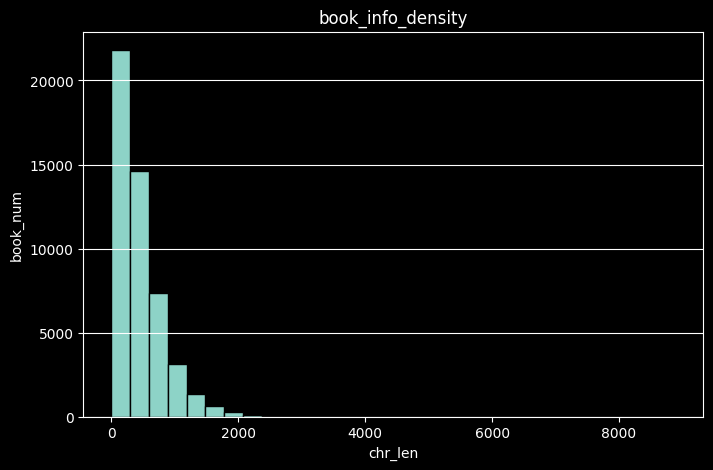

268


In [ ]:
import matplotlib.pyplot as plt

df["book_info_char_count"] = df["책소개"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)

plt.figure(figsize=(8, 5))
plt.hist(df["book_info_char_count"], bins=30, edgecolor="black")
plt.title("book_info_density")
plt.xlabel("chr_len")
plt.ylabel("book_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_info_char_count"] > 2000].shape[0])

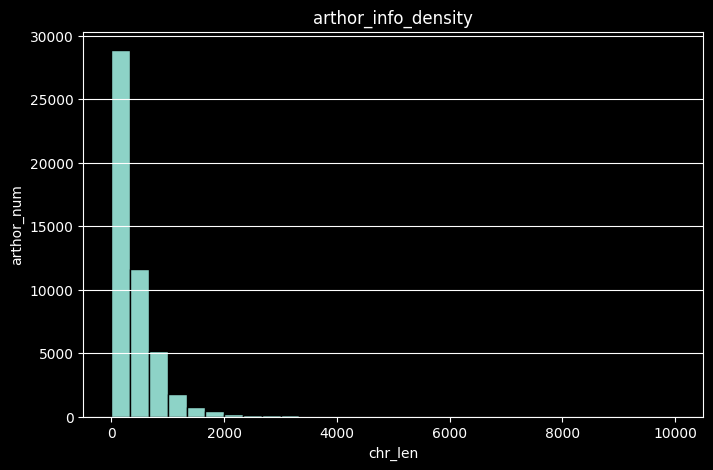

760


In [ ]:
df["arthor_info_char_count"] = df["저자소개"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["arthor_info_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("arthor_info_density")
plt.xlabel("chr_len")
plt.ylabel("arthor_num")
plt.grid(axis="y")
plt.show()
print(df[df["arthor_info_char_count"] > 2000].shape[0])

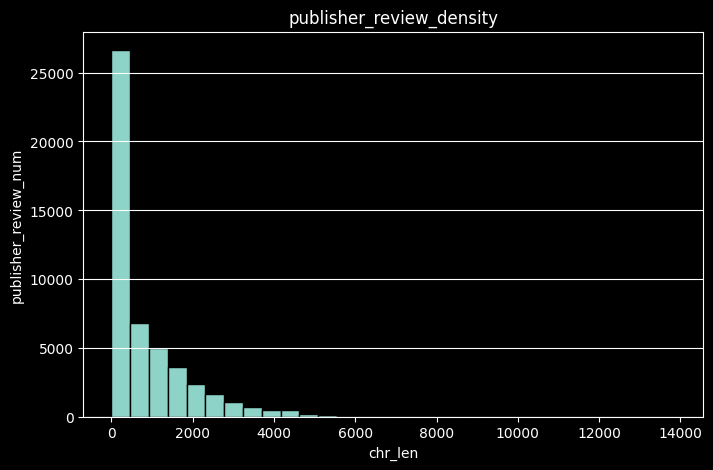

6380


In [ ]:
df["publisher_review_char_count"] = df["출판사리뷰"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["publisher_review_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("publisher_review_density")
plt.xlabel("chr_len")
plt.ylabel("publisher_review_num")
plt.grid(axis="y")
plt.show()
print(df[df["publisher_review_char_count"] > 2000].shape[0])

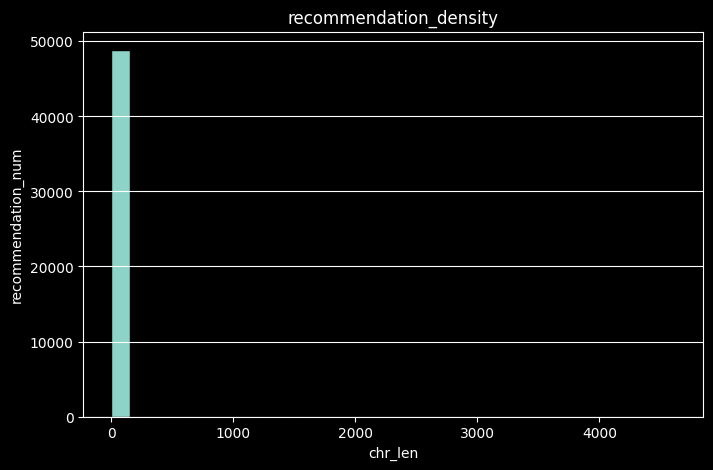

25


In [ ]:
df["recommendation_char_count"] = df["추천사"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["recommendation_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("recommendation_density")
plt.xlabel("chr_len")
plt.ylabel("recommendation_num")
plt.grid(axis="y")
plt.show()
print(df[df["recommendation_char_count"] > 2000].shape[0])

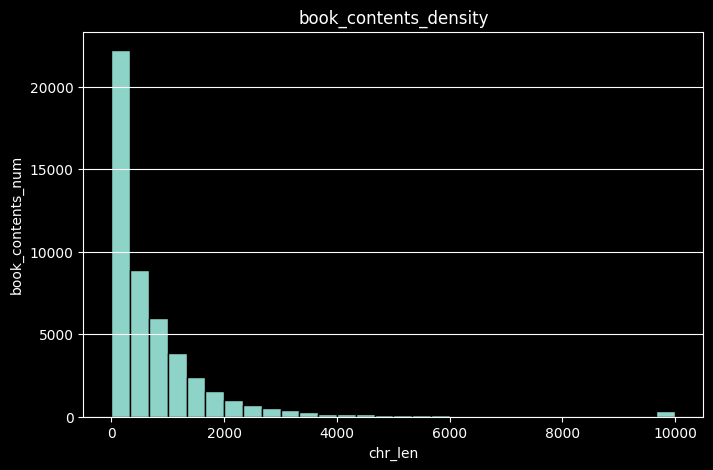

4436


In [ ]:
df["book_contents_char_count"] = df["목차"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["book_contents_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("book_contents_density")
plt.xlabel("chr_len")
plt.ylabel("book_contents_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_contents_char_count"] > 2000].shape[0])

In [24]:
df.describe()

,Unnamed: 0,ISBN,페이지,가격,book_info_char_count,arthor_info_char_count,publisher_review_char_count,recommendation_char_count,book_contents_char_count
count,49340.000000,4.934000e+04,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000,49340.000000
mean,24877.532813,9.790525e+12,320.283766,23148.908188,442.092825,381.821990,815.481577,8.389887,818.412789
std,14386.374785,1.004030e+09,326.937973,31070.165112,383.687546,554.468741,1169.532414,105.850005,1304.171684
min,0.000000,9.788900e+12,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12402.750000,9.788984e+12,168.000000,12000.000000,166.000000,19.000000,0.000000,0.000000,117.000000
50%,24878.500000,9.791159e+12,256.000000,16000.000000,341.000000,243.000000,352.000000,0.000000,413.000000
75%,37330.250000,9.791187e+12,376.000000,24000.000000,609.000000,536.000000,1239.000000,0.000000,992.000000
max,49826.000000,9.791199e+12,20160.000000,980000.000000,8885.000000,10000.000000,13872.000000,4620.000000,10000.000000


In [ ]:
import requests
import uuid

# Clova Studio Tokenizer API 설정
# C:\Kill_the_RAG\Project\Aiffel_final_project\.env 여기 경로에 있는 NCP_CLOVASTUDIO_API_KEY 이걸로 API키만 받아와서 아래 코드 알맞게게 작성

# API 키 불러오기
API_KEY = os.getenv("NCP_CLOVASTUDIO_API_KEY")  # .env 파일에 저장된 API 키

MODEL_NAME = "LK-D2"  # 모델명 확인
url = f"https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/tokenize/{MODEL_NAME}"

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
    "X-NCP-CLOVASTUDIO-REQUEST-ID": str(uuid.uuid4()),
}

payload = {"text": df["책소개"][20751]}  # 20751번 텍스트 선택

response = requests.post(url, headers=headers, json=payload)

# 결과 출력
print("URL:", url)
print("STATUS:", response.status_code)
print("RESPONSE:", response.text)

URL: https://clovastudio.apigw.ntruss.com/testapp/v1/api-tools/tokenize/LK-D2
STATUS: 200
RESPONSE: {"status":{"code":"20000","message":"OK"},"result":{"numTokens":872}}


In [ ]:
API_KEY = os.getenv("NCP_CLOVASTUDIO_API_KEY")

MODEL_NAME = "LK-D2"  # 모델명 확인
TOKENIZER_URL = (
    f"https://clovastudio.apigw.ntruss.com/v1/api-tools/tokenize/{MODEL_NAME}"
)


headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
    "X-NCP-CLOVASTUDIO-REQUEST-ID": str(uuid.uuid4()),
}


# 토큰 계산
def calculate_tokens(text):
    payload = {"text": text}
    response = requests.post(TOKENIZER_URL, headers=headers, json=payload)

    if response.status_code == 200:
        tokens = response.json().get("result", {}).get("numTokens", 0)
        return tokens
    else:
        print("Error calculating tokens:", response.text)
        return 0


# Chain of Density
def chain_of_density(text, iterations=5):
    total_tokens = 0  # 사용 토큰 계산
    current_text = text

    # ChatClovaX
    llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)

    for i in range(1, iterations + 1):
        # 매 iteration 마다 토큰 수 계산
        tokens_used_in_text = calculate_tokens(current_text)
        total_tokens += tokens_used_in_text

        # prompt
        prompt = f"""
        다음은 점차적으로 간결하고, 중요한 정보를 밀집시킨 요약을 생성하는 작업입니다.

        위 기사의 점점 더 간결한 요약을 5번 반복하여 작성하세요.

        **반복할 두 가지 단계는 다음과 같습니다:**

        **1단계.** 이전에 생성된 요약에서 누락된 1-3개의 유의미한 엔티티(구체적인, 중요한 정보)를 식별하세요. 누락된 엔티티는:
        - 기사의 주요 내용과 관련이 있다.
        - 간결하지만 구체적이다(100자 이하).
        - 이전 요약에 포함되지 않았다.
        - 기사의 내용에 충실하다.
        - 기사의 어느 부분에도 포함될 수 있다.

        **2단계.** 이전 요약에서 다룬 모든 엔티티와 세부 사항을 포함하여 누락된 엔티티를 추가한, 같은 길이의 더 밀집된 요약을 작성하세요.

        *누락된 엔티티는:*
        - 관련성 있는 주제와 연결된 엔티티여야 한다.
        - 이전 요약에서 언급되지 않은 새롭고 중요한 정보여야 한다.
        - 기사의 주요 내용을 정확하게 전달해야 한다.
        - 기사의 모든 내용을 요약에 포함할 수 있어야 한다.

        **지침:**
        - 첫 번째 요약은 길이가 길고(8-10문장, 약 200자) 비특이적이어야 하며, 누락된 엔티티 외에는 많은 정보가 포함되지 않도록 작성하세요. 너무 verbose한 언어와 filler 문장을 사용하여 약 200단어에 맞추세요.
        - 다음 요약은 이전 요약을 개선하여 흐름을 개선하고, 추가 엔티티를 위한 공간을 만드세요.
        - 이전 요약에서 다루지 않은 엔티티들을 추가할 때, **중복되거나 불필요한 문장**은 제거하거나 압축하여 공간을 확보하세요.
        - 요약은 점점 더 밀집하고 간결해지며, **자체적으로 이해할 수 있어야 합니다.** 이 기사를 읽지 않고도 독자가 이해할 수 있게 만들어야 합니다.
        - **누락된 엔티티는** 새 요약에 어디에나 나타날 수 있으며, **이전 요약에서 제외된 엔티티**를 반드시 포함하세요.

        - 각 요약은 동일한 길이(약 200자)여야 합니다.
        - JSON 형태로 작성해야 하며, **각 항목은 "Missing_Entities"와 "Denser_Summary"**로 이루어져야 합니다.

        반복 {i}:
        {current_text}
        """

        # 요약 text 얻고 iteration 마다 전달하도록
        messages = [
            {"role": "system", "content": "이 시스템은 요약을 담당합니다."},
            {"role": "user", "content": prompt},
        ]

        response = llm_clova.invoke(messages)

        # 응답으로 text 추출
        summary_text = response.content  # content

        # 출력: 각 iteration마다 사용된 토큰 수와 요약된 텍스트 같이 출력
        print(f"Iteration {i}:")
        print(f"Text after iteration {i}: {summary_text}")
        print(f"Tokens used in iteration {i}: {tokens_used_in_text}\n")

        # iteration 후 text
        current_text = summary_text

    print(f"Total tokens used after {iterations} iterations: {total_tokens}")
    return current_text, total_tokens

In [ ]:
# 초기 텍스트 로드
initial_text = df["책소개"][20751]

# Chain of Density 실행
final_text, final_tokens = chain_of_density(initial_text, iterations=3)
print(f"Final summary after 5 iterations: {final_text}")

Iteration 1:
Text after iteration 1: 반복 1:
이 책은 노인의학 전문의들이 노인환자를 평가하고 치료 및 관리하는 방법을 설명하며, 증례를 통해 이를 제시한다. 또한, 노인증후군(노쇠, 낙상, 거동장애, 실금, 섬망, 인지기능 저하) 에 대해 자세히 기술하며, 이외에도 약물 부작용, 치매의 행동정신증상(BPSD), 뇌졸중, 우울증, 심방세동, 수축기 고혈압, 심부전, 골관절염 등 노인에서 흔한 임상문제도 다룬다. 게다가, 노인환자를 만나는 다양한 환경(급성기 병원, 외래진료, 요양시설, 재활시설) 에서 노인환자를 평가하고 다학제 팀을 구성하며, 환자 관리법을 알려준다. 책의 마지막 부분에서는 노인윤리, 사전돌봄계획, 완화의료에 대해 자세히 설명한다. 

```json
{
  "Missing_Entities": [
    "노인증후군",
    "약물 부작용, 치매의 행동정신증상(BPSD), 뇌졸중, 우울증, 심방세동, 수축기 고혈압, 심부전, 골관절염",
    "노인윤리, 사전돌봄계획, 완화의료"
  ],
  "Denser_Summary": "이 책은 노인 증후군에 대해 자세히 기술하며, 노인에서 흔한 임상 문제인 약물 부작용, 치매의 행동 증상, 뇌졸중, 우울증, 심방 세동, 고혈압, 관절염 등도 다룹니다. 또한, 노인 윤리, 사전 돌봄 계획 및 완화 의료에 대한 자세한 설명도 포함되어 있습니다."
}
```
Tokens used in iteration 1: 872

Iteration 2:
Text after iteration 2: 반복 3:
이 책은 노인증후군 뿐만 아니라 노쇠, 낙상, 거동장애, 실금, 섬망, 인지기능 저하 와 같은 여러가지 질병들에 대해 다루고 있고, 그 외에도 약물 부작용, 치매의 행동 정신 증상, 뇌졸중, 우울증, 심방세동, 수축기 고혈압, 심부전, 골관절염 등 노인에게 자주 발생하는 질환들에 대해서도 자세하게 설명해주고 있다. 그리고 노인 급성기 병원, 외래 진료, 요양 시설, 재활 시설에서의 노인 환

In [ ]:
df["책소개"][20751]

'이 책을 읽은 분들이 노인 진료에서 작은 기적을 경험하기를 기대하며 이 책은 노인의학 전문의들이 실제 어떻게 노인환자를 평가하고 치료하고 관리하는지를 잘 설명하고 있습니다. 특히, 증례로 시작해서 문제를 제기하고 내용 구성에 맞게 증례의 경과와 실제 관리방법을 제시하고 마지막에 치료(관리) 결과를 증례에 제시함으로써 노인의학적 지식이 실제 어떻게 구현되는지를 보여줌으로써 한층 이해를 높이고 있습니다. 주변에 노인의학 관련 책들이 많이 나와 있지만, 많은 경우 노인에 흔한 질환들을 중심으로 구성된 것들이 많아서 노인의학 정신을 배우기는 쉽지 않습니다. 노인의학이란 노인의 질병에 초점을 맞추는 것과 더불어 각 노인 개인의 특성, 삶의 질을 고려해야하는 학문이기 때문입니다. 그런데 이 책은 바로 노인의학의 철학이 무엇인지, 노인의학이 왜 단순히 내과학문의 연장선이 아닌지를 잘 보여주고 있습니다. 특히, 이 책에서는 질병으로 분리되지 않지만 노인에 흔하고 중요한 문제인 여러 노인증후군(노쇠, 낙상, 거동장애, 실금, 섬망, 인지기능 저하)에 대해 자세히 기술함으로써 다른 의학서적에서는 배우기 어려운 노인의학 핵심을 잘 다루고 있습니다. 이러한 노인증후군은 일반의사들이 잘 진단하지 못하고 잘 관리하지 못하는 문제이며, 흔히 ‘나이가 들어서 그런 것’이라고 치부해버리고 관리를 포기하는 경우가 많은데, 이들 노인증후군을 어떻게 관리하는가에 따라 환자의 기능과 예후가 크게 달라지게 됩니다. 물론 이 책에서 약물 부작용, 치매의 행동정신증상(BPSD), 뇌졸중, 우울증, 심방세동, 수축기 고혈압, 심부전, 골관절염 등과 같이 노인에서 흔한 임상문제에 대해서도 다루고 있어서 임상의로서는 매우 반갑고 유익합니다. 그리고 노인환자를 만나게 되는 다양한 환경, 즉, 급성기 병원, 외래진료, 요양시설, 그리고 재활시설에서 어떻게 노인환자를 평가하고 다학제 팀을 구성하며, 환자를 관리하는지를 상황별로 제시하고 있어서 노인진료의 넓은 스펙트럼을 잘 소개하고 있습니다. 마지막으로 이 책에